In [4]:
# (48000, 28, 28) 크기인 train_input이
# (48000, 28, 28, 1) 크기인 train_scaled이 되었다.
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)


### 합성곱 신경망 만들기
- Sequential 클래스의 객체를 만들고 첫 번째 합성곱 층인 Conv2D를 추가
- 모델의 add() 메서드를 사용해 층을 하나씩 차례대로 추가

In [14]:
# 32개의 필터 사용, 커널 크기는 (3, 3), relu 함수, same padding
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))

In [15]:
# (28 28)크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일
# (2,2) 풀링을 적용 -> 특성 맵의 크기는 줄어듬. (28, 28, 32) -> (14, 14, 32)
model.add(keras.layers.MaxPooling2D(2))

In [16]:
# 첫번째 합성곱-풀링층 다음에 두번째 합성곱-풀링층 추가. 둘다 거이 동일(필터의 개수만 64개로 늘런거 뻬고)
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [17]:
# 3차원 특성맵을 일렬로 펼침, 이유는 마지막의 10개의 뉴런을 가진 출력층에서 확률을 계산하기 때문.
# 특성맵을 일렬로 펼처서 바로 출력층에 전달하지 말고, 중간의 하나의 밀집 은닉층(hidden layer)를 하나 둠.
# 요약하면 Flatten class 다음, Dense 은닉층, 마지막으로 Dense 출력층 순서대로 구성
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu')) # 뉴런 100개
model.add(keras.layers.Dropout(0.4)) # 은닉층과 출력층 사이에 드롭아웃을 넣음, 과대적합 방지
model.add(keras.layers.Dense(10, activation='softmax')) 

In [18]:
# 합성곱 (1 -> 2, 32 -> 64)
# 특성맵의 크기는 첫번째, 2번째 풀링 거치면서 28->14->7. 최종 (7,7,64)
# 모델 파라미터 (32개 필터, 크기 (3,3), 길이는 1) = 3*3*1*32+32=320개, 2번째 3*3*32*64+64=18,946개
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [24]:
!pip install pydot

In [28]:
# layer의 구성을 그림으로 표현, 근데 안떠
from keras.utils import plot_model
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 모델 컴파일과 훈련

In [35]:
# Adam optimizer 사용, ModelCheckpoint callback, EarlyStopping callback 함께 사용 -> 조기 종료 기법 구현
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 11s 8ms/step - loss: 0.1613 - accuracy: 0.9390 - val_loss: 0.2308 - val_accuracy: 0.9210
Epoch 2/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1487 - accuracy: 0.9437 - val_loss: 0.2461 - val_accuracy: 0.9198
Epoch 3/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1400 - accuracy: 0.9478 - val_loss: 0.2565 - val_accuracy: 0.9232


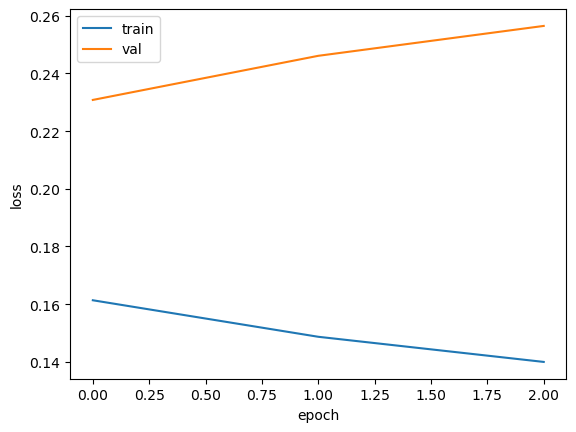

In [36]:
# 손실그래프 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [37]:
# 성능 평가
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2308 - accuracy: 0.9210


[0.23082375526428223, 0.9210000038146973]

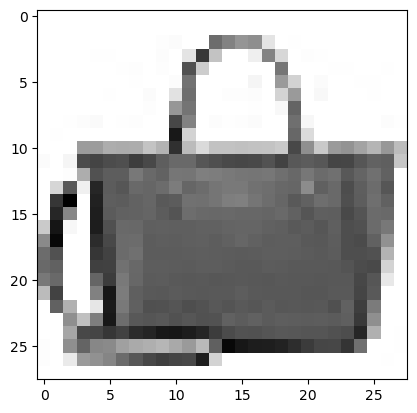

In [38]:
# predict() 메서드를 사용해 훈련된 모댈을 사용하여 새로운 데이터에 대해 예측
# 흑백 이미지에 깊이 차원은 없습니다 따라서 (28, 28, 1) 크기를 (28, 28)로 비꾸어 출력
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [39]:
# model의 이미지에 대한 예측. predict() method는 10개의 클래스에 대한 예측 확률 출력
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 111ms/step
[[8.5227049e-24 8.6019171e-30 2.6766198e-29 4.3814117e-23 1.5551462e-24
  1.1046955e-18 5.0970029e-26 3.9025124e-25 1.0000000e+00 1.8065394e-27]]


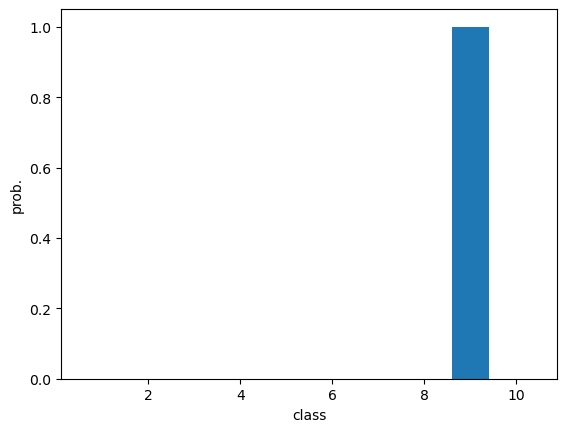

In [40]:
# 다른 클래스의 값들은 사실상 모두 0, 9번째 클래스가 실제로 무엇인지는 패션 Mnist dataset 정의를 참고해야함
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [41]:
# label 정의를 다루기 위해서 리스트로 저장
# 클래스 리스트가 있으면 label을 출력하기 쉽다.
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [42]:
# preds 배열에서 가장큰 인덱스를 찾아 classes 리스트의 인덱스로 사용
import numpy as np
print(classes[np.argmax(preds)])

가방


In [43]:
# 샘플을 가방으로 잘 예측, 테스트 세트로 합성곱 신경망의 일반화 성능을 가늠
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [44]:
# 91%의 성능 기대
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 2ms/step - loss: 0.2539 - accuracy: 0.9197


[0.25387856364250183, 0.919700026512146]